In [145]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow_addons as tfa
from nltk.corpus import stopwords
import gensim as gs
import re
import string
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay 


 Configuração para GPU

In [146]:
devices = tf.config.experimental.list_physical_devices('GPU')

try:
    tf.config.experimental.set_memory_growth(devices[0], True)
    print("Success")
except:
    print("Exception occured")
    pass

Exception occured


In [147]:
df = pd.read_csv('../data/pre-processed.csv')
df = df.drop(columns=['index'])
df.isnull().any()

label                False
preprocessed_news    False
dtype: bool

In [148]:

stop_words = set(stopwords.words('portuguese'))

def remover_stop_words(news):
    palavras = news.split()
    palavras_sem_stop = [palavra for palavra in palavras if palavra.lower() not in stop_words]
    return ' '.join(palavras_sem_stop)

def review_cleaning(text):
    
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df["preprocessed_news"] = df["preprocessed_news"].apply(remover_stop_words)
df["preprocessed_news"] = df["preprocessed_news"].apply(review_cleaning)

In [149]:
df['label'] = df.apply(lambda row: 0 if row.label == 'fake' else 1, axis=1)

X = df.drop(['label'], axis = 1)
Y = df['label']

In [150]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify=Y)

X_train = X_train['preprocessed_news'].apply(lambda x: x.lower())
X_test = X_test['preprocessed_news'].apply(lambda x: x.lower())

train_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
train_tokenizer.fit_on_texts(X_train.values)
train_word_index = train_tokenizer.word_index


In [151]:
train_sequences = train_tokenizer.texts_to_sequences(X_train)
vocab_length = len(train_word_index) + 1
test_sequences = train_tokenizer.texts_to_sequences(X_test)

print(f'Vocab length {vocab_length}, Train sequences {len(train_sequences)}, Test sequences {len(test_sequences)} ')

Vocab length 73007, Train sequences 5760, Test sequences 1440 


In [152]:
maxlen=256
train_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post', maxlen=maxlen, truncating='post')
test_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding='post', maxlen=maxlen, truncating='post')

In [153]:
output_dim = 64
tf.keras.backend.clear_session()


modelSimpleRNN = tf.keras.models.Sequential()
modelSimpleRNN.add(tf.keras.layers.Embedding(vocab_length, output_dim, input_length=maxlen))
modelSimpleRNN.add(tf.keras.layers.GRU(60, activation='tanh', return_sequences=True))
modelSimpleRNN.add(tf.keras.layers.Conv1D(30, 3, activation='relu'))
modelSimpleRNN.add(tf.keras.layers.LSTM(30, return_sequences=True))
modelSimpleRNN.add(tf.keras.layers.SimpleRNN(3, activation='tanh'))
modelSimpleRNN.add(tf.keras.layers.Dropout(0.25))
modelSimpleRNN.add(tf.keras.layers.Dense(24, activation='relu'))
modelSimpleRNN.add(tf.keras.layers.Dense(units = 1, activation='sigmoid'))

modelSimpleRNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modelSimpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 64)           4672448   
                                                                 
 gru (GRU)                   (None, 256, 60)           22680     
                                                                 
 conv1d (Conv1D)             (None, 254, 30)           5430      
                                                                 
 lstm (LSTM)                 (None, 254, 30)           7320      
                                                                 
 simple_rnn (SimpleRNN)      (None, 3)                 102       
                                                                 
 dropout (Dropout)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 24)                9

In [154]:
epochs = 10
batch_size = 30

historySimpleRNN = modelSimpleRNN.fit(train_padded_seqeunces, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/10
173/173 [==============================] - 37s 182ms/step - loss: 0.3766 - accuracy: 0.8953 - val_loss: 0.2508 - val_accuracy: 0.9219
Epoch 2/10
173/173 [==============================] - 29s 169ms/step - loss: 0.2511 - accuracy: 0.9309 - val_loss: 0.2292 - val_accuracy: 0.9306
Epoch 3/10
173/173 [==============================] - 29s 169ms/step - loss: 0.2123 - accuracy: 0.9323 - val_loss: 0.1760 - val_accuracy: 0.9358
Epoch 4/10
173/173 [==============================] - 29s 170ms/step - loss: 0.1324 - accuracy: 0.9549 - val_loss: 0.2103 - val_accuracy: 0.9288
Epoch 5/10
173/173 [==============================] - 29s 170ms/step - loss: 0.0920 - accuracy: 0.9701 - val_loss: 0.2226 - val_accuracy: 0.9358
Epoch 6/10
173/173 [==============================] - 30s 171ms/step - loss: 0.0711 - accuracy: 0.9745 - val_loss: 0.2365 - val_accuracy: 0.9236
Epoch 7/10
173/173 [==============================] - 29s 169ms/step - loss: 0.0589 - accuracy: 0.9776 - val_loss: 0.2624 - val_ac

Avaliação do conjunto de testes

45/45 [==============================] - 3s 39ms/step


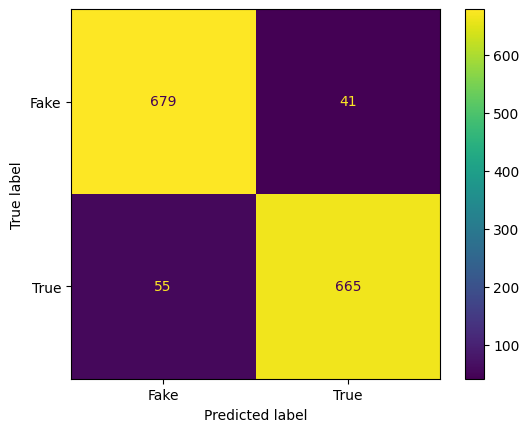

In [156]:


y_train_pred = modelSimpleRNN.predict(test_padded_seqeunces)
y_train_pred = (y_train_pred > 0.70)
cm = confusion_matrix(y_test, y_train_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()


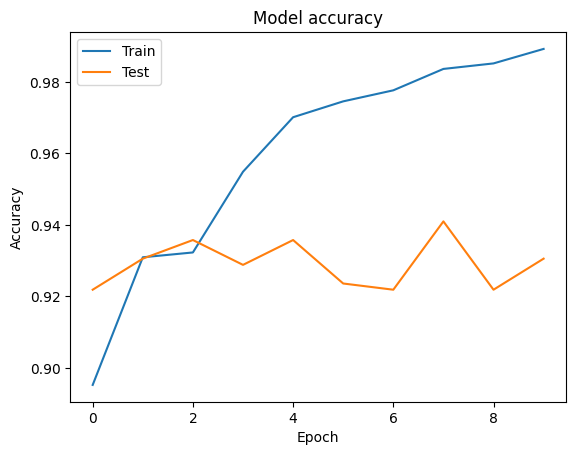

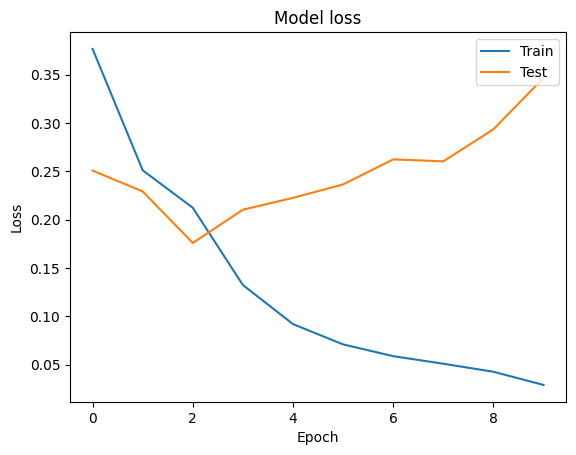

In [157]:

plt.plot(historySimpleRNN.history['accuracy'])
plt.plot(historySimpleRNN.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(historySimpleRNN.history['loss'])
plt.plot(historySimpleRNN.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Salva modelo

Model Testing

In [ ]:
   
news1 = 'Bolsonaro recebe intimacao justica escreve letras esgarranchadas'
news2 = 'No nosso governo são cinco por ano [invasões de terra]'

news = [news1, news2]

def output_lable(n):
    if n == 1:
        return "Fake News"
    elif n == 0:
        return "Not A Fake News"
    
def manual_testing(news):
    testing_news = {"text":news}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(remover_stop_words)

    new_x_test = new_def_test["text"]
    new_xv_test = train_tokenizer.texts_to_sequences(new_x_test)
    new_xv_test = tf.keras.preprocessing.sequence.pad_sequences(new_xv_test, padding='post', maxlen=maxlen, truncating='post')

    pred_news = modelSimpleRNN.predict(new_xv_test)
    return pred_news            
       
pred_news = manual_testing(news)

print("\n\nSimpleRNN Prediction: {} news is {}".format(pred_news[0], output_lable(pred_news[0])))
print("\n\nSimpleRNN Prediction: {} news is {}".format(pred_news[1], output_lable(pred_news[1])))

cm = confusion_matrix([1,0], pred_news)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()


1/1 [==============================] - 1s 691ms/step


SimpleRNN Prediction: [6.0033716e-13] news is None


SimpleRNN Prediction: [4.4297574e-10] news is None


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [100]:
inv_index = {v: k for k, v in train_tokenizer.word_index.items()}
for w in new_xv_test[0]:
    x = inv_index.get(w)
    print(x,end = ' ')


NameError: name 'new_xv_test' is not defined